In [27]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pysal.lib import weights
import numpy as np
from shapely.geometry import Polygon
import rioxarray

#### Contiguity weights

spatial relationships are bi-directional, while temporal relationships are unidirectional.

In [2]:
# Get points in a grid
l = np.arange(3)
xs, ys = np.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = gpd.GeoSeries(polys)
gdf = gpd.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)
gdf

,geometry,id
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",P-00
1,"POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....",P-01
2,"POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....",P-02
3,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",P-03
4,"POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....",P-04
5,"POLYGON ((2.00000 1.00000, 3.00000 1.00000, 3....",P-05
6,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",P-06
7,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",P-07
8,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3....",P-08


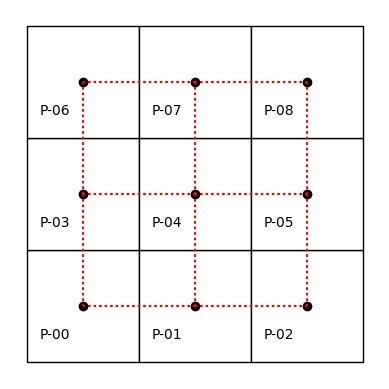

In [3]:
ax = gdf.plot(facecolor="w", edgecolor="k")

# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )

# Build a rook contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wr = weights.contiguity.Rook.from_dataframe(gdf, use_index=False)

# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)

# Remove axes
ax.set_axis_off()

In [29]:
wr.full()

(array([[0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.]]),
 [0, 1, 2, 3, 4, 5, 6, 7, 8])

In [4]:
# Build a queen contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wq = weights.contiguity.Queen.from_dataframe(gdf, use_index=False)
wq.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

(<Figure size 1000x700 with 1 Axes>, <Axes: >)

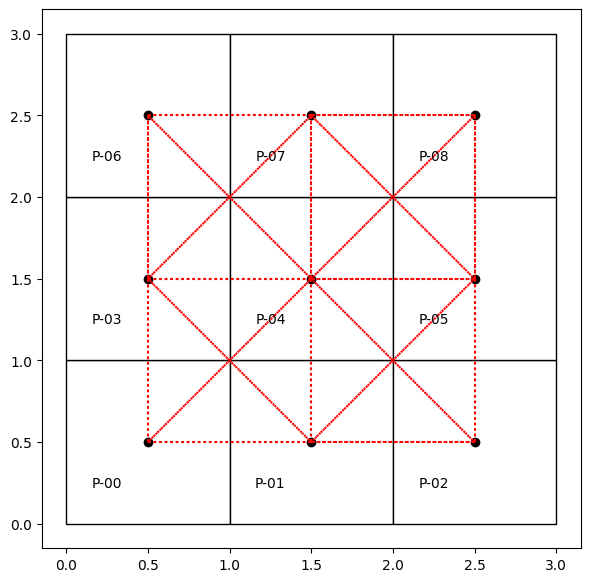

In [5]:
ax = gdf.plot(facecolor="w", edgecolor="k", figsize=(10, 7))

# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )


# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)

In [8]:
# number of joins
wq.s0

40.0

In [9]:
wq.pct_nonzero

49.382716049382715

### Spatial weights from real-world geographic table

In [14]:
san_diego_tracts = gpd.read_file(
    "data/sandiego_tracts.gpkg"
)
w_queen = weights.contiguity.Queen.from_dataframe(
    san_diego_tracts, use_index=False)
w_queen

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

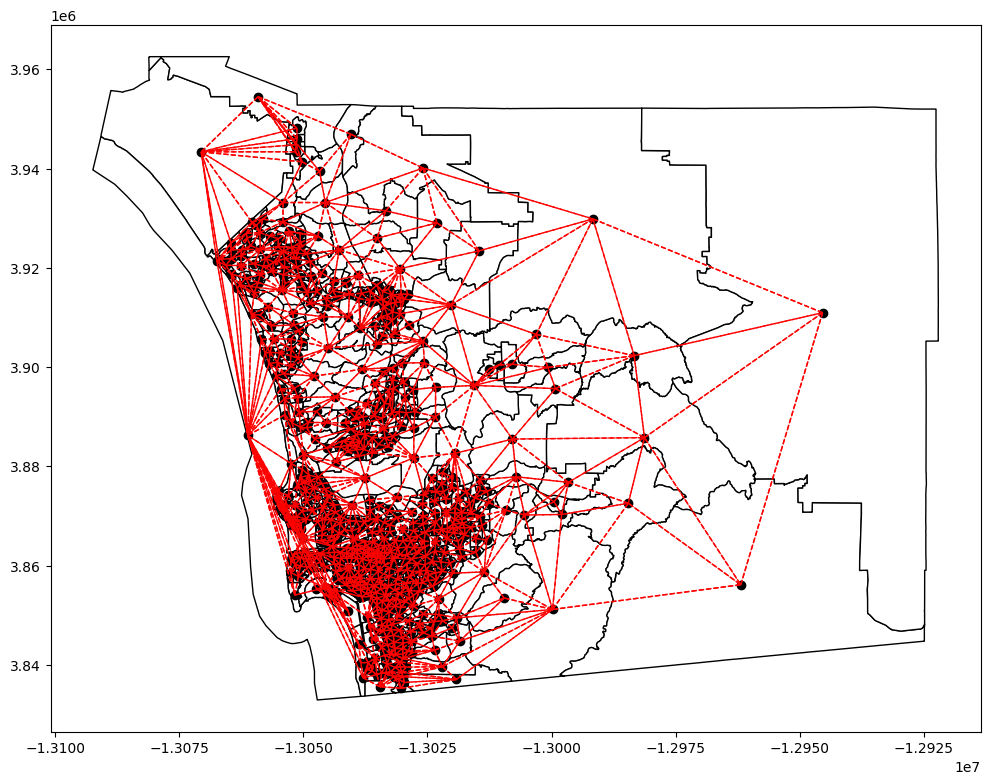

In [25]:
ax = san_diego_tracts.plot(facecolor='w', edgecolor='k', figsize=(12, 10))
w_queen.plot(san_diego_tracts, edge_kws={
             'color': 'r', 'lw': 1, 'ls': '--'}, ax=ax)

### Spatial weights from surfaces

In [32]:
sao_paulo = rioxarray.open_rasterio("data/ghsl_sao_paulo.tiff")
sao_paulo

<xarray.DataArray (band: 1, y: 416, x: 468)>
[194688 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
  * y            (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -200.0
    scale_factor:   1.0
    add_offset:     0.0

In [37]:
w_sao_paulo = weights.contiguity.Queen.from_xarray(sao_paulo)

In [39]:
wk4 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=4)

In [40]:
wk4.islands

[]

In [42]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

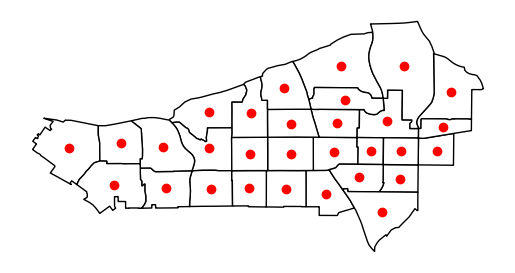

In [43]:
# Create subset of tracts
sub_30 = san_diego_tracts.query("sub_30 == True")
# Plot polygons
ax = sub_30.plot(facecolor="w", edgecolor="k")
# Create and plot centroids
sub_30.head(30).centroid.plot(color="r", ax=ax)
# Remove axis
ax.set_axis_off()